In [1]:
using Random
using Distributions
using FFTW
using LinearAlgebra 
using Arpack 
using Plots
using LaTeXStrings

In [2]:
#sigma=0.1; 
theta=0.5;  #the twist
Nreal=1000;  #number of samples 

tk(n,sig,ll,th)=-sign(cos(2.0*pi*n/ll+th/ll))*abs(cos(2.0*pi*n/ll+th/ll))^sig; #k-space Hamiltonian

In [3]:
Nbox=25;   #number of boxes (which should be selected such that L/Nbox must be integer)
q = 0.4;        #exponent in generalized inverse participation ratio 
NW = 20;    # number of disorder strengths
ws=0.05;    # step size of disorder strength 


## function to find intersection

function find_intersect(a,b,c,d)
    
    k1 = (b[2]-a[2])/(b[1]-a[1]);        #slope of line 1
    
    k2 = (d[2]-c[2])/(d[1]-c[1]);        #slope of line 2
    
    x = ((c[2]-a[2])+(k1*a[1]-k2*c[1]))/(k1-k2);   #x-coordinate of the intersection 
    
    y = k1*(x - a[1]) + a[2];                      #y-coordinate of the intersection
    
    return [x,y] 
    
end
  

Random.seed!(234) #setting the seed 

LL=[100,400]

S=[0.1:0.4:0.9;]

wc=zeros(length(S));

for s in 1:length(S)
    
    sigma=S[s];

    Alpha_q = zeros(NW,length(LL));

    for l in 1:length(LL)

        L=LL[l]; 

        lambda = (L/Nbox)/L;   #aspect ratio

        alpha_q = zeros(NW);


        for w in 1:NW

            W=ws*w

    #         dis=Normal(0.0, W) 


            Rq=zeros(Nreal);
            Sq=zeros(Nreal);

            for ireal in 1:Nreal 

    #             Vx=rand(dis,L);#generating random potential according to normal distribution
                Vx = W.*randn(L)
                Vk=fft(Vx)/L;        #Fourier transform of random potential
    #            Vk=fftshift(Vk);   #moving the zero potential to the center of the spectrum 
                Vkk=sum(Vx);       #diagonal element of V_{k,k'}

                Ham=zeros(Complex{Float64},L,L);          #initializing the Hamiltonian matrix with zeros
    #            vecs=zeros(Complex{Float64},L,L);         #initializaing the eigenvectors with zeros 

                for i in 1:L
                   for j in 1:L
                       if i==j
                           Ham[i,j]=tk(i,sigma,L,theta) #+ Vkk/L
                       elseif i<j
                           Ham[i,j]=Vk[j-i+1]
                       else
                           Ham[i,j]=conj(Vk[i-j+1])
                        end
                    end
                end

                en0, evec0=eigs(Ham,nev=1,which=:SM); 

                Nr = sum(abs.(evec0).^2);   #normalization

                mu=zeros(Nbox);    
                for k in 1:Nbox
                    mu[k]=sum(abs.(evec0[((k-1)*div(L,Nbox))+1:k*div(L,Nbox)]).^2)/Nr;
                end

                #alpha=mu./(log(lambda)); 

                Rq0=sum(mu.^q);
                Sq0=sum((mu.^q).*(log.(mu))); 

                Rq[ireal]=Rq0;
                Sq[ireal]=Sq0;
            end

            alpha_q0=(sum(Sq)/Nreal)/((sum(Rq)/Nreal)*log(lambda)); 

            alpha_q[w]=alpha_q0; 

        end

        Alpha_q[:,l] = alpha_q;

    end
    
    if Alpha_q[:,1][1]<=Alpha_q[:,2][1]
        bc = maximum(findall(x->x==0, (Alpha_q[:,1]-Alpha_q[:,2]).>0))
        ac = bc+1 
    else 
        bc = maximum(findall(x->x==1, (Alpha_q[:,1]-Alpha_q[:,2]).>0))
        ac = bc+1
    end
    
    x0, y0 = find_intersect([ws*bc,Alpha_q[:,1][bc]],[ws*ac,Alpha_q[:,1][ac]],[ws*bc,Alpha_q[:,2][bc]],[ws*ac,Alpha_q[:,2][ac]])
    
    wc[s]=x0;

end    

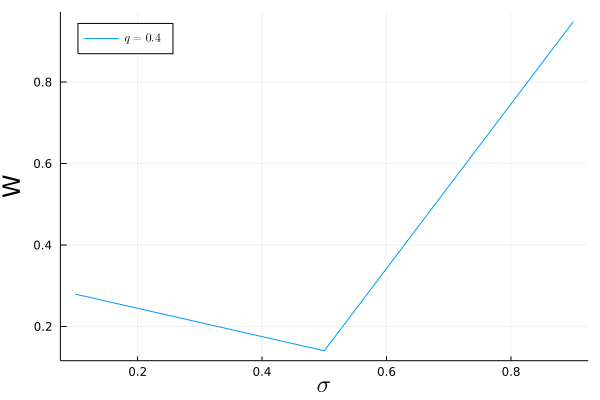

In [19]:
plot(S,wc,xlabel=L"\sigma",ylabel='W',fmt = :png, guidefont=font(16),
    legend=:topleft,label=L"q=0.4")

In [12]:
wc[1]

0.2793812980861432

In [9]:
wc[2]

0.1403101231454281

In [10]:
wc[3]

0.9481689440713841

In [13]:
S[3]

0.9